# ECG data analysis

Using the PTB-XL data, this notebook:
1. Loads the data
2. Explores the metadata,
3. Vizuales the signal data in interactive figures
4. Summarized a theory and literature review.
5. Extracts wave-features and explores the useage of a codebase for multilabel diagnostic classification, to expand on in future instance. 

Note: on the first run, the second call will make the runtime crash to downgrade fastai to an older version.

In [1]:
## In this cell, set 'show_all_figs = False'
## if you want to save RAM for model training:
show_all_figs = True

In [2]:
!pip list

fastai_version = !pip show fastai
if fastai_version[1][-6:] != '1.0.61':
  !pip install fastai==1.0.61 ## required to downgrade to use some code later 
  import os
  os.kill(os.getpid(), 9) # Restart the runtime to use the new fastai

Package                       Version
----------------------------- ----------------------------
absl-py                       1.2.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.4
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.8

In [3]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
## Import the libraries we will use in our initial exploration:
from pathlib import Path
import os
import requests
import zipfile
from google.colab import drive
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import wfdb
import ast

## Allow "hot-reloading" of modules
%load_ext autoreload
%autoreload 2

## 1. Loading the data

In [23]:
### Cell to download the zipped data and unzip it

##############################
# If the following flag is set to True, the data will be downloaded to your Drive
# folder for easy reuse. Otherwise to the current directory.
load_from_drive = True
##############################

## Downloads the zipped data from 'physionet.org':
if load_from_drive:
  drive.mount('/content/drive/')
  zip_folder = Path("/content/drive/MyDrive/PTB-XL")
  # Don't load the data again if it already exists:
  if not zip_folder.exists():
    zip_folder.mkdir(parents=True, exist_ok=True)
    os.chdir(zip_folder)
    !wget -r -N -c https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2.zip
  else:
    print("--- Zipfile already downloaded to Drive. We'll use this file.")
else:
  zip_folder = Path("/content")
  !wget -r -N -c https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2.zip

## Unzip the data:
os.chdir("/content")
data_folder = Path('/content/')
data_folder.mkdir(parents=True, exist_ok=True)
# Don't unzip if the data has already been unzipped:
if not (data_folder / 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2').exists():  
  # Unzip:
  with zipfile.ZipFile(zip_folder / 'physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2.zip', 'r') as zip_ref:
      print('--- Unzipping...')
      zip_ref.extractall(data_folder)
      print('--- Successfully unzipped the data')
data_folder = data_folder / 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
--- Zipfile already downloaded to Drive. We'll use this file.


## 2. Exploring the metadata

In [24]:
# Read and have a look at the metadata - enable interactive dataframes
# below the dataframe to scroll through all the columns:
Y = pd.read_csv(data_folder / 'ptbxl_database.csv', index_col='ecg_id')
Y.head(10)

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,SLI-LVH,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,False,False,False,False,False,False,False,False,False,False
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,False,False,False,False,False,False,False,False,False
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False
6,19005.0,18.0,1,NaN,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False
7,16193.0,54.0,0,NaN,83.0,2.0,0.0,CS-12 E,1984-11-28 13:32:22,"sinusrhythmus linkstyp t abnormal, wahrscheinl...",...,False,False,False,False,False,False,False,False,False,False
8,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,sinusrhythmus linkstyp qrs(t) abnormal infe...,...,False,False,False,False,False,False,False,False,False,False
9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False


### 2A. ecg_id, patient_id, age, sex, nurse, site, device, recording_date



`patient_id` and `sex` are coded as floats. Check if there are NAs or non-integer values:

In [25]:
print(f"Dataframe size: {Y.shape}\n")
display(Y.isna().sum())
print("\nPercent-wise:\n")
display((Y.isna().sum() / Y.shape[0]).round(3))

Dataframe size: (21801, 43)



patient_id                          0
age                                 0
sex                                 0
height                          14826
weight                          12379
nurse                            1475
site                               18
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8470
infarction_stadium1             16188
infarction_stadium2             21698
validated_by                     9380
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20202
static_noise                    18541
burst_noise                     21188
electrodes_problems             21771
extra_beats                     19852
pacemaker                       21510
strat_fold                          0
filename_lr                         0
filename_hr 


Percent-wise:



patient_id                      0.000
age                             0.000
sex                             0.000
height                          0.680
weight                          0.568
nurse                           0.068
site                            0.001
device                          0.000
recording_date                  0.000
report                          0.000
scp_codes                       0.000
heart_axis                      0.389
infarction_stadium1             0.743
infarction_stadium2             0.995
validated_by                    0.430
second_opinion                  0.000
initial_autogenerated_report    0.000
validated_by_human              0.000
baseline_drift                  0.927
static_noise                    0.850
burst_noise                     0.972
electrodes_problems             0.999
extra_beats                     0.911
pacemaker                       0.987
strat_fold                      0.000
filename_lr                     0.000
filename_hr 

A few sites are missing. Some more nurses as well.

In [26]:
display(np.array_equal(Y.patient_id, Y.patient_id.astype(int)))
display(np.array_equal(Y.age, Y.age.astype(int)))

True

True

So we can safely convert to int:

In [27]:
Y['patient_id'] = Y['patient_id'].astype('int32')
Y['age'] = Y['age'].astype('int32')

In [28]:
px.histogram(Y, x = 'sex', histnorm='probability density').show()
px.histogram(Y, x = 'age').show()

- Skew distribution. 
- Local peak at 18/19 - how did this arise? 
- 293 people > 89.


In [29]:
n_reports_per_patient = Y.groupby('patient_id').apply(lambda x: x.shape[0])
fig = px.histogram(n_reports_per_patient)
fig.update_layout(title = 'Histogram of number of ecg recordings per patient')

We see that a sizeable proportion of patients have more than 2 readings, with the extreme of 1 patient with 10 readings, 3 patients with 9 readings, 4 with 8, 5 with 7, 16 with 6, ... **Note:** All these figures are interactive. You can hover over values, zoom in by selecting a zone in the graph, ...

In [30]:
Y.device.value_counts(dropna = False)

CS100    3    6140
CS-12         4048
AT-6 C 5.5    3950
CS-12   E     2879
AT-6     6    2273
AT-60    3     966
AT-6 C 5.8     824
AT-6 C         515
AT-6 C 5.0      80
AT-6 C 5.3      67
AT-6 C 5.6      59
Name: device, dtype: int64

In [31]:
Y.site.value_counts(dropna = False)

0.0     8940
1.0     6294
2.0     5075
3.0      577
4.0      100
5.0       58
6.0       46
8.0       43
7.0       43
9.0       38
10.0      37
11.0      33
12.0      26
14.0      26
15.0      25
13.0      24
16.0      22
17.0      20
21.0      18
20.0      18
NaN       18
18.0      17
27.0      15
28.0      15
19.0      15
22.0      15
23.0      15
26.0      15
29.0      15
24.0      14
25.0      13
32.0      13
31.0      13
30.0      12
36.0      12
34.0      12
35.0      11
33.0      10
38.0      10
37.0      10
40.0       9
41.0       9
39.0       8
44.0       7
45.0       6
42.0       6
43.0       6
48.0       4
46.0       4
47.0       4
49.0       3
50.0       2
Name: site, dtype: int64

5 sites with the majority of the measurements at the first 3 sites. TODO: check whether the distribution is the same across folds. First, set these as category:

In [32]:
Y['site'] = Y['site'].astype('category')
Y['device'] = Y['device'].astype('category')

In [33]:
Y['site'].isna().sum()

18

In [34]:
Y['nurse'] = Y['nurse'].astype('category')
Y['nurse'].value_counts(dropna = False)

0.0     8295
1.0     5709
NaN     1475
5.0      648
3.0      642
2.0      639
7.0      639
4.0      635
6.0      631
8.0      626
10.0     626
11.0     619
9.0      617
Name: nurse, dtype: int64

Interesting, not many nurses? One, or a team, that did 8k+ readings.

In [35]:
Y.groupby('nurse')['site'].nunique()

nurse
0.0     2
1.0     3
2.0     1
3.0     2
4.0     1
5.0     2
6.0     2
7.0     2
8.0     2
9.0     2
10.0    1
11.0    2
Name: site, dtype: int64

Most nurses work on multiple sites.

In [36]:
# Now, let's have a look at the recording times:
Y['recording_date'] = pd.to_datetime(Y['recording_date'])
px.histogram(Y, x = 'recording_date')

- That's a long scope, in which perhaps protocols, devices and health conditions/treatments could have been changed. **Note:** Would be interesting to investigate later.
- There seems to be some periodicity.
- Steady increase and then decrease in measurements. **Q:** Why the decrease?

In [37]:
Y['report'] = Y['report'].astype('str') # More for later

### 2B. scp_codes

In [38]:
# Use the given code from the zip to process scp codes; turns them into dicts:
if not type(Y.scp_codes.iloc[0]) == dict:
  Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [39]:
Y.scp_codes.iloc[:10]

ecg_id
1     {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                 {'NORM': 80.0, 'SBRAD': 0.0}
3                   {'NORM': 100.0, 'SR': 0.0}
4                   {'NORM': 100.0, 'SR': 0.0}
5                   {'NORM': 100.0, 'SR': 0.0}
6                   {'NORM': 100.0, 'SR': 0.0}
7                   {'NORM': 100.0, 'SR': 0.0}
8       {'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}
9                   {'NORM': 100.0, 'SR': 0.0}
10                  {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, dtype: object

In [40]:
# The scp statements can be found in scp_statements.csv
df_scp = pd.read_csv(data_folder / 'scp_statements.csv', index_col=0)
display(df_scp.shape)
df_scp.head()

(71, 12)

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [41]:
df_scp['diagnostic'].value_counts(dropna = False)

1.0    44
NaN    27
Name: diagnostic, dtype: int64

In [42]:
# Use the scp_code information to update our metadata using the provided code:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in df_scp.index:
            tmp.append(df_scp.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass_all'] = Y.scp_codes.apply(aggregate_diagnostic)

# Use the scp_code information to update our metadata:
df_scp_filtered = df_scp[~df_scp['diagnostic'].isna()]
def aggregate_diagnostic_filtered(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in df_scp_filtered.index:
            tmp.append(df_scp_filtered.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic_filtered)

In [43]:
Y[['scp_codes', 'diagnostic_superclass_all', 'diagnostic_superclass']]

,scp_codes,diagnostic_superclass_all,diagnostic_superclass
ecg_id,,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}","[nan, NORM]",[NORM]
2,"{'NORM': 80.0, 'SBRAD': 0.0}","[nan, NORM]",[NORM]
3,"{'NORM': 100.0, 'SR': 0.0}","[nan, NORM]",[NORM]
4,"{'NORM': 100.0, 'SR': 0.0}","[nan, NORM]",[NORM]
5,"{'NORM': 100.0, 'SR': 0.0}","[nan, NORM]",[NORM]
...,...,...,...
21833,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...","[nan, STTC]",[STTC]
21834,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}","[nan, NORM]",[NORM]
21835,"{'ISCAS': 50.0, 'SR': 0.0}","[nan, STTC]",[STTC]


In [44]:
df_scp.loc[['LVOLT', 'SR'],:]

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
LVOLT,low QRS voltages in the frontal and horizontal...,NaN,1.0,NaN,NaN,NaN,Other QRS morphology descriptive statements,low QRS voltages in the frontal and horizontal...,NaN,NaN,NaN,NaN
SR,sinus rhythm,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,sinus rhythm,20.0,MDC_ECG_RHY_SINUS_RHY,NaN,NaN


Are there ones that don't appear at all in the scp_code frame?

In [45]:
# Use the scp_code information to update our metadata:
def aggregate_diagnostic(y_dic):
    tmp = 0
    for key in y_dic.keys():
        if key not in df_scp.index:
            tmp+=1
    return tmp

# Apply diagnostic superclass
Y['scp_not_listed'] = Y.scp_codes.apply(aggregate_diagnostic)
Y.loc[Y['scp_not_listed'] > 0, 'scp_codes']


Series([], Name: scp_codes, dtype: object)

In [46]:
df_scp_filtered['diagnostic_class'].isna().sum()

0

All of them are in the scp dataframe at least, but some don't have a class.

**TODO:** For later potentially, make likelihood-based multi-label encodings of superclasses? Need to account for multiple scp_codes belonging to the same class potentially.

In [47]:
Y.diagnostic_superclass.value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[NORM]                 9072
[MI]                   2532
[STTC]                 2401
[CD]                   1708
[CD, MI]               1300
[STTC, HYP]             781
[MI, STTC]              600
[HYP]                   535
[CD, STTC]              471
[NORM, CD]              407
[]                      405
[MI, STTC, HYP]         361
[CD, HYP]               300
[CD, MI, STTC]          223
[CD, STTC, HYP]         211
[MI, HYP]               183
[CD, MI, STTC, HYP]     156
[CD, MI, HYP]           117
[NORM, STTC]             28
[NORM, CD, STTC]          5
[NORM, CD, HYP]           2
[NORM, HYP]               2
[NORM, CD, MI, HYP]       1
Name: diagnostic_superclass, dtype: int64

### 2C. Heart Axis, Infarction Stadia1/2, baseline_drift, static_noise, ...

Some quick initial checks. More later when used.

In [48]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH',
       'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC',
       'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL',
       'diagnostic_superclass_all', 'diagnostic_superclass', 'scp_not_listed'],
      dtype='object')

In [49]:
for clm in ['heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'baseline_drift', 'static_noise', 'burst_noise', 'baseline_drift', 'electrodes_problems', 'extra_beats']:
  print(f"\n{clm} - value counts:\n")
  display(Y[clm].value_counts(dropna = False))


heart_axis - value counts:



NaN     8470
MID     7687
LAD     3764
ALAD    1382
RAD      221
ARAD     122
AXL      101
AXR       51
SAG        3
Name: heart_axis, dtype: int64


infarction_stadium1 - value counts:



NaN               16188
unknown            3431
Stadium III         980
Stadium II-III      943
Stadium I           166
Stadium II           88
Stadium I-II          5
Name: infarction_stadium1, dtype: int64


infarction_stadium2 - value counts:



NaN            21698
Stadium III       65
Stadium I         19
Stadium II        19
Name: infarction_stadium2, dtype: int64


baseline_drift - value counts:



NaN                     20202
 , V6                     221
 , V1                      94
 , II-AVF                  60
 , V3                      59
                        ...  
 , III,AVF,V5,V6            1
 , I,II,V1,V5,V6            1
 , I - AVF,V3               1
II,III,AVF,V1-V3, V6        1
 , AVR,AVF,V3               1
Name: baseline_drift, Length: 319, dtype: int64


static_noise - value counts:



NaN                           18541
 , I-AVR,                       953
 , I-AVF,                       919
 , alles,                       522
 , I-V1,                        156
                              ...  
 , V5,V6,                         1
 , I-AVL,V5,V6,                   1
 , I,III,V5,                      1
 , I,II,III,AVR,AVL,AVF,          1
 , I-V1,V6,                       1
Name: static_noise, Length: 125, dtype: int64


burst_noise - value counts:



NaN             21188
alles             140
I-AVF              47
V1                 46
V1,V2              28
                ...  
v1-2                1
I,III,V5,V6         1
V3-V5               1
I,II,AVL-V6         1
II-AVL,V1,V2        1
Name: burst_noise, Length: 104, dtype: int64


baseline_drift - value counts:



NaN                     20202
 , V6                     221
 , V1                      94
 , II-AVF                  60
 , V3                      59
                        ...  
 , III,AVF,V5,V6            1
 , I,II,V1,V5,V6            1
 , I - AVF,V3               1
II,III,AVF,V1-V3, V6        1
 , AVR,AVF,V3               1
Name: baseline_drift, Length: 319, dtype: int64


electrodes_problems - value counts:



NaN                         21771
V6                              8
V4                              5
V1                              4
V1???                           2
V5                              2
V3                              1
V5,V6                           1
Kontaktprobleme aVL ???         1
I???                            1
aVL???                          1
v6????                          1
Elektroden vertauscht???        1
v4, v5                          1
V3,V4-V6                        1
Name: electrodes_problems, dtype: int64


extra_beats - value counts:



NaN                19852
1ES                  405
SVES                 381
2ES                  179
VES                  159
                   ...  
2,I,III-V1             1
VES,SVES5,alles        1
2,V2                   1
V1,2,3,4,6             1
4ES,SVES               1
Name: extra_beats, Length: 129, dtype: int64

Potentially analyse electrode problems separately. Not many however.

#### 2D. Folds

Let's here do a few basic checks on the folds. As suggested, let's group folds 1-8 together as train. 9 as validation and 10 as test.

After this check, let's put away folds 9 and 10, not even looking at exploratory analyses to avoid basing non-model informed hypotheses (figures, ...) on the validation and test data.

In [50]:
Y['strat_fold'].value_counts(dropna=False)

10    2198
3     2192
9     2183
2     2181
7     2176
1     2175
5     2174
4     2174
8     2174
6     2174
Name: strat_fold, dtype: int64

In [51]:
Y_train = Y[(~Y.strat_fold.isin([9,10]))]
Y_val   = Y[Y.strat_fold == 9]
Y_test  = Y[Y.strat_fold == 10]

def fold_type(strat_fold):
  if strat_fold < 8.5:
    return 'train'
  elif strat_fold == 9:
    return 'val'
  else:
    return 'test'

Y['fold_type'] = Y['strat_fold'].apply(fold_type)
  

In [52]:
px.histogram(Y, x = 'recording_date', color = 'fold_type', histnorm='probability density', barmode = 'overlay', opacity = .3)

In [53]:
px.histogram(Y, x = 'recording_date', color = 'fold_type')

Most months seem to be represented. There's much more train data proportionally in the recent months/years and older months/years don't always have much val/test data. We may have to test for stability of properties/hypotheses/models.

## 3. ECG data

Finally the main substance of data.

Let's use the given loading code:

In [54]:
Y.filename_lr

ecg_id
1        records100/00000/00001_lr
2        records100/00000/00002_lr
3        records100/00000/00003_lr
4        records100/00000/00004_lr
5        records100/00000/00005_lr
                   ...            
21833    records100/21000/21833_lr
21834    records100/21000/21834_lr
21835    records100/21000/21835_lr
21836    records100/21000/21836_lr
21837    records100/21000/21837_lr
Name: filename_lr, Length: 21801, dtype: object

In [55]:
%%time

# Adapted the physionet code to also return one meta object dictionnary, as inspection:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path / f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path / f) for f in df.filename_hr]
    meta0 = data[0][1]
    data = np.array([signal for signal, meta in data])
    return data, meta0

sampling_rate = 100

# Load raw signal data
X_train, meta0 = load_raw_data(Y_train, sampling_rate, data_folder)

CPU times: user 55.2 s, sys: 6.2 s, total: 1min 1s
Wall time: 1min 5s


In [56]:
print(type(X_train))
X_train.shape

<class 'numpy.ndarray'>


(17420, 1000, 12)

In [57]:
display(meta0)
channels = meta0['sig_name']

{'fs': 100,
 'sig_len': 1000,
 'n_sig': 12,
 'base_date': None,
 'base_time': None,
 'units': ['mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV'],
 'sig_name': ['I',
  'II',
  'III',
  'AVR',
  'AVL',
  'AVF',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6'],
 'comments': []}

In [58]:
X_train[:3,:10, :2]

array([[[-0.119, -0.055],
        [-0.116, -0.051],
        [-0.12 , -0.044],
        [-0.117, -0.038],
        [-0.103, -0.031],
        [-0.097, -0.025],
        [-0.119, -0.014],
        [-0.096,  0.008],
        [-0.048,  0.044],
        [-0.037,  0.045]],

       [[ 0.004,  0.138],
        [-0.02 ,  0.116],
        [-0.053,  0.092],
        [-0.056,  0.089],
        [-0.062,  0.083],
        [-0.065,  0.076],
        [-0.061,  0.078],
        [-0.061,  0.08 ],
        [-0.064,  0.081],
        [-0.061,  0.092]],

       [[-0.029, -0.079],
        [-0.035, -0.07 ],
        [-0.054, -0.057],
        [-0.078, -0.12 ],
        [-0.088, -0.061],
        [-0.022, -0.017],
        [ 0.346,  0.251],
        [ 0.784,  0.572],
        [ 0.426,  0.248],
        [-0.076, -0.035]]])

In [59]:
# path = data_folder / Y.filename_lr.iloc[0]

# record = wfdb.rdrecord(path)
# annotation = wfdb.rdann(str(path), 'hea')

# wfdb.plot_wfdb(record=record, annotation=annotation,
#                title='test',
#                time_units='test')

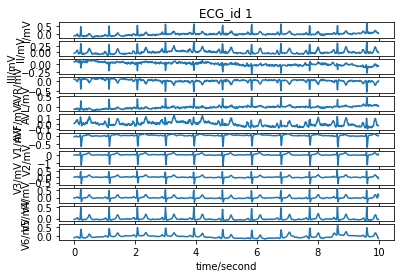

None

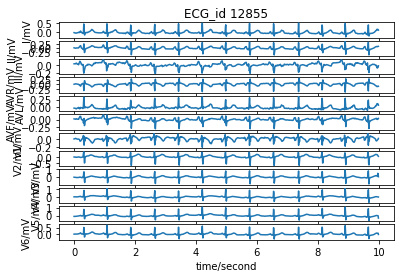

None

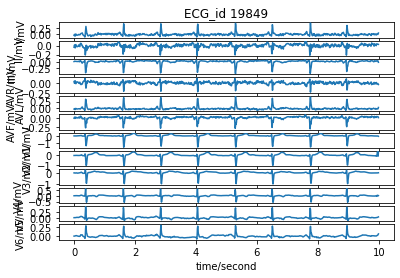

None

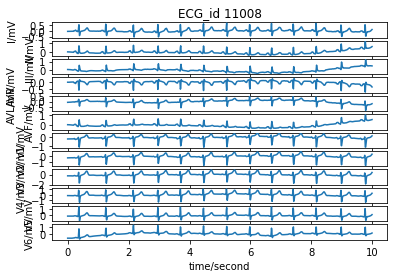

None

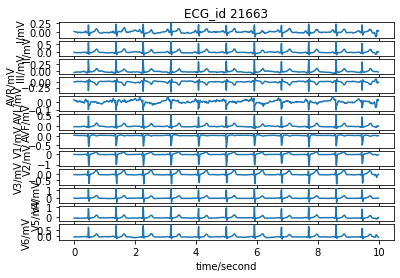

None

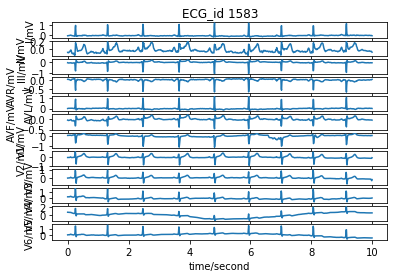

None

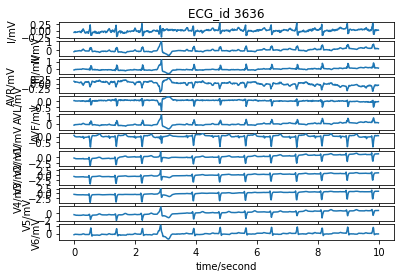

None

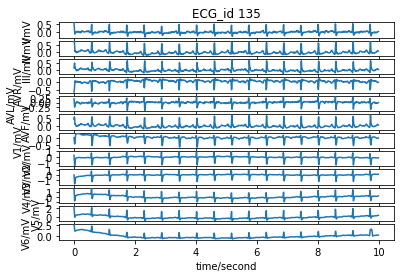

None

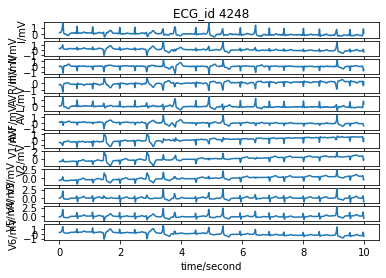

None

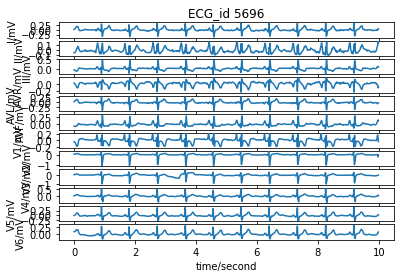

None

In [60]:
idxs = [0,10001, 15678, 8543, 17263] + list(np.random.randint(0, high = X_train.shape[0] + 1, size = (5))) # Would be better to only look at train data

for idx in idxs:
  ecg_id = Y_train.index[idx]
  path = data_folder / Y_train.filename_lr.iloc[idx]
  record = wfdb.rdrecord(path)
  display(wfdb.plot_wfdb(record=record, title=f'ECG_id {ecg_id}'))

In these two examples, there are trends and cyclical patterns in some of the streams. We can also see interbeat intervals that are longer than usual. For other deviations from prototypical beat-to-beat curves, we'll have to look more in-depth.

Let's make interactive figures first, where it's possible to zoom in, read off values easily etc.

In [61]:
channels

['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [62]:
# Quantiles of the signal overall, for offsets in the new figures:
np.quantile(X_train, [.001, .005, .01, .5, .99, .995, .999])

array([-1.855, -0.999, -0.692, -0.01 ,  0.757,  1.028,  1.716])

In [63]:
#go.Figure(go.Histogram(x = X_train.flatten()))

In [64]:
from plotly.subplots import make_subplots

# def structured_interactive_signal_plot(idxs: np.array, X: np.array, Y: pd.DataFrame, sampling_rate: int, channels = np.arange(12, dtype = np.int32)) -> None:
#   """
#   Takes a 2D numpy array with the ECG signal of one subject,
#   and plots these in interactive figures.

#   Inputs:
#   - idx: 1D np array or list of indices to subset from X
#   - X: 3D numpy array of shape (.,., 12)
#   - Y: corresponding metadata dataframe
#   - sampling_rate: the sampling rate, to determine the X-axis units
#   - channels: list of ints, the indices of the channels to be displayed
#   """
#   channel_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

#   colors = px.colors.qualitative.Dark24
#   print("---------------------------------------------------------------------")
#   for s_idx in idxs: # subject_index:
#     X_subject = X[s_idx, :, :]
#     scp_code = Y.scp_codes.iloc[s_idx]
#     ecg_id = Y.index[s_idx]

#     fig = make_subplots(rows=len(channels), cols=1, shared_xaxes=True, vertical_spacing=0.02)
#     for n_idx, idx in enumerate(channels):
#       X_i = X_subject[:, idx]
#       max_size = max(1.02 * max(np.max(X_i), - np.min(X_i)), 2.)

#       fig.append_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = X_subject[:,idx], name = channel_names[idx], marker_color = colors[idx]), row = n_idx + 1, col = 1)
#       fig.update_yaxes(range = [-max_size,max_size], row =n_idx+1, col = 1)
#       fig.append_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = np.zeros(X_subject.shape[0]), marker_color = 'black', line = dict(width = 1.),  showlegend = False), row = n_idx + 1, col =1)
#       #if idx != 11:
#       #  fig.update_yaxes(nticks = 0)
#       #fig.add_hline(y=23. - 2. * idx, )
#     fig.update_layout(title = f'ECG id: {ecg_id}, scp: {scp_code}')
#     fig.show()
#     print("---------------------------------------------------------------------")

def structured_interactive_signal_plot2(idxs: np.array, X: np.array, Y: pd.DataFrame, sampling_rate: int, channels = np.arange(12, dtype = np.int32)) -> None:
  """
  Takes a 2D numpy array with the ECG signal of one subject,
  and plots these in interactive figures.

  Inputs:
  - idx: 1D np array or list of indices to subset from X
  - X: 3D numpy array of shape (.,., 12)
  - Y: corresponding metadata dataframe
  - sampling_rate: the sampling rate, to determine the X-axis units
  - channels: list of ints, the indices of the channels to be displayed
  """
  channel_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

  colors = px.colors.qualitative.Dark24
  print("---------------------------------------------------------------------")
  for s_idx in idxs: # subject_index:
    X_subject = X[s_idx, :, :]
    scp_code = Y.scp_codes.iloc[s_idx]
    ecg_id = Y.index[s_idx]

    fig = go.Figure()
    for n_idx, idx in enumerate(channels):
      fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = X_subject[:,idx] + 2. * (len(channels) - n_idx), name = channel_names[idx], marker_color = colors[idx]))
      fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = np.zeros(X_subject.shape[0]) + 2. * (len(channels) - n_idx), marker_color = 'black', line = dict(width = 1.),  showlegend = False))
    fig.update_layout(title = f'ECG id: {ecg_id}, scp: {scp_code}', yaxis = dict(showticklabels=False))
    fig.show()
    print("---------------------------------------------------------------------")


In [65]:
idxs = [123, 8736, 10078, 15987, 4586, 2987, 14274, 12529]

if show_all_figs:
  structured_interactive_signal_plot2(idxs, X_train, Y_train, sampling_rate, channels = np.arange(12, dtype = np.int32))

Output hidden; open in https://colab.research.google.com to view.

Looking at these handpicked examples we see several patterns:
- 124 seems to have baseline drift
- Looks fairly smooth. Have read about wavelet smoothing being applied in this case however.

In [66]:
display(Y_train.iloc[idxs][['scp_codes','baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'r_peaks', 'diagnostic_superclass' ]])

,scp_codes,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,r_peaks,diagnostic_superclass
ecg_id,,,,,,,,,
200,"{'NORM': 100.0, 'SR': 0.0}",", II-V6",NaN,NaN,NaN,NaN,NaN,[ 52 138 223 304 385 467 551 635 721 804 884 963],[NORM]
11241,"{'ASMI': 50.0, 'ABQRS': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,[ 66 139 212 285 358 430 502 574 647 718 790 8...,[MI]
12950,"{'CLBBB': 100.0, 'AFIB': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,[ 7 54 96 134 171 230 268 308 383 429 469 5...,[CD]
20221,"{'NORM': 80.0, 'SARRH': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,[ 28 98 171 240 310 377 447 519 589 658 723 7...,[NORM]
6036,"{'NORM': 80.0, 'QWAVE': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,[ 11 100 182 265 355 448 541 633 728 823 914],[NORM]
4024,"{'EL': 50.0, 'PAC': 0.0, 'NT_': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,[ 9 77 144 213 283 352 419 488 558 627 694 7...,[STTC]
18126,"{'IRBBB': 100.0, 'LAFB': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,[ 19 102 187 271 357 444 531 617 704 790 877 963],[CD]
15978,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,[ 72 145 217 289 361 434 506 578 650 722 795 8...,[NORM]


In [67]:
# TODO in heatmap
Y_train.groupby('device')[['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats']].apply(lambda x: (~x.isna()).sum() / x.shape[0])


,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats
device,,,,,
AT-6 6,0.050248,0.019326,0.019326,0.001657,0.054114
AT-6 C,0.199324,0.179054,0.013514,0.033784,0.081081
AT-6 C 5.0,0.192308,0.057692,0.038462,0.000000,0.115385
AT-6 C 5.3,0.040000,0.000000,0.000000,0.020000,0.040000
AT-6 C 5.5,0.050489,0.023667,0.013885,0.000316,0.054591
AT-6 C 5.6,0.081633,0.020408,0.000000,0.000000,0.061224
AT-6 C 5.8,0.057692,0.023669,0.013314,0.000000,0.053254
AT-60 3,0.031148,0.216393,0.006557,0.000000,0.103279
CS-12,0.097371,0.133654,0.008886,0.001481,0.103665


Let's have a look at static_noise, burst_noise, electrodes_problems and pacemaker:

In [68]:
if show_all_figs:
  for clm in ['static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker']:
    mask = ~Y_train[clm].isna().reset_index(drop=True)
    idxs = mask[mask].index
    idxs = np.random.choice(idxs, size = (2))

    print(f'\n{clm}:')
    display(Y_train.iloc[idxs,:][['scp_codes','baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
        'extra_beats', 'pacemaker', 'r_peaks', 'diagnostic_superclass' ]])
    structured_interactive_signal_plot2(idxs, X_train, Y_train, sampling_rate, channels = np.arange(12, dtype = np.int32))
  


Output hidden; open in https://colab.research.google.com to view.

## 4. Background and literature study

### 4.1. ECG signal theory basics

Before looking more at the signal, with or without regards to classification of the scp_codes, let's try to understand the 12 signals and scp_codes from a theoretical point of view.

If we understand how trained physicians make diagnoses basesd on the signals, this can help us in understanding their structure, and predicting them. It also opens up avenues to compare diagnostic/form/rhythm labels to structure learned from the data.

#### Source 1

https://www.youtube.com/watch?v=Rv6l0ViRJDQ

Notes:
1. V1- V6 run from the center to the left leg over the chest, AVL is on the left shoulder, AVR on the right shoulder, AVF on the left foot. The right foot electrode is a neutral. I is between AVL and AVR, II between AVR and AVF and III between AVF and AVR. 
2. The different parts of the heart usually pump at different timespans from one another, creating a symphony. Atrio to ventricals.
3. Atria > Ventricals
4. SA node > Av Node > Hiss bundle > Purkinje
5. ECG readings are from the myocardium.

#### Source 2: ECG basics

https://www.youtube.com/watch?v=CNN30YHsJw0

Lead II signal walkthrough:
1. P-wave: atrial depolarization SA going to AV node
2. Flat line: AV becomes depolarized but holds electrical activity before sending down to ventricles. PR-segment from end of P until beginning of R. PR-interval from beginning of P.
3. Q-wave: electrical wave goes down bundle of hiss. It's mostly the left bundle branch that depolarizes the intraventricular septum. This makes the mean vector go towards the right slightly up. (don't fully understand the why of this yet). The Q-wave is indicative of septal depolarization.
  - If they become very wide or deep, or in other locations: pathological Q-waves. Sometimes you may not even see them in a 12-lead ECG.
4. R-wave: Signal goes into the Purkinje system. The left ventricle has more myocardium so carries more current. So more current towards left side, slightly down. Big peak because of all the myocardium.
5. S-wave: at the end, the polarization moves up. So slight negative wave on II-lead.
6. ST segment: Iso-electric point: similar as the AV node keeping the depolarization, now we have this in the ventricular wall. Getting ready to repolarize. Important part when it comes to pathologies.
7. T-wave: repolarization of the ventricular walls and septum.

Other leads:
1. I and III look similarly topologically to II, though with potential differences in the sizes of all.
  - Lead I gives an idea about the High Lateral wall of the Left Ventrical.
  - Leads II and III gives an idea about the inferior wall/portion of the heart.
2. avR: inverted topology from II. Focused on basal septum and right ventrical. 
3. avL, avF: similar to II. There might be slight variations from machine to machine. avL: high lateral wall of left ventrical. avF: The inferior wall of the heart.
4. Precordial leads: Uni-polar leads. From V1 to V5/6, R wave gets bigger. Maximal negative S wave around V2. Or maybe in V1? This info may be used for axis deviation, atrophy, ... 
  - V1 - V3: focus on right ventrical (+aVR)
  - V2 - V3: basal septum (+aVR)
  - V2 - V4: anterior wall
  - V5 - V6: lateral wall of left ventrical (+I, avL)

More information on the printed out device sheet:
1. big box width is 0.20s. big box height is 0.5mV (less important). 
2. PR-Interval less than 0.20sec is considered normal.
3. QRS-complex: less than 0.12sec
4. QT-interval: many variations of 'normal': male $<$ 0.430s, female: $<$ 0.460s.

#### Source 3: ECG interpretation:

https://www.youtube.com/watch?v=TTYGxK1DNKA&t=361s

- II, III, avF: Inferior wall
- I, AVL, V5-6: Lateral wall of left ventricle
- avR, V1-2: right ventricle
- V1- V4: Anteroseptal

**Rate and Rhythm:**
- Rate: > 100beats per minute is tachycardia
- Rhythm: R-R interval not constant: irregular
- QRS-window: >0.12s is wide
- sinus P-waves present? P0wave upright in Lead II, inverted P-wave in AVR, every P followed by QRS.
- PR-interval: normal, prolonged, constant, variable, progressively longer? (<.2 for normal)

**Subdivision Tachycardia:**
division by narrow/wide QRS and regular/irregular rhythm

**Subdivision of bradycardia:**

**ST-segments:**

First, they focused on things that have a higher likelihood of mortality. Now ST-segment:
1. ST-segment elevation: if > 0.1mV in any of the leads V2-V3.
2. ST-depression:
  1. downsloping
  2. horizontal: concerning signs of ischemia
  3. upsloping

**J-wave:**
Before S-wave quick little blip before T wave.

**T-wave:**
- T-wave inversion. (V1-V2 + III)
- hyperacute
- biphasic
- flat (between $\pm$0.1mV)
- peaked

**QRS-complex:**

Is there intercranial pressure? Pulmonary ...

#### Data hypothesis ideas & questions

There are much more video series on the different diagnoses, but we understand basic structure and diagnosing now.

here are a few things we can explore in different forms of complexity:
1. Process the signals to extract the wave features. Start with predicting a few diagnoses marginally. Then go to multi-label or multi-class prediction. We can do this based on likelihoods (better) or rounding. (Alternatively r_peaks can be predicted, but that seems less interesting now.r_peaks can be used as an extra validation of features however.)
2. Use whole-signal based data-driven methods to predict labels directly.
3. Try to combine wave-features, whole-signal and static info such as sex. (age may reflect too much data-collection info, but we can explore this as well)
3. This seems an interesting one to me: cluster the time series and derived features. See if physician-derived diagnoses align with these clusters. Are there clusters that are not well-captured by diagnoses? Are there waves between say normal and a diagnosis that could indicate early signs of evolution towards a diagnosis?
4. Compare different readings of the same patient and study the long-term evolution. Potentially find early signs retrospectively of later different diagnoses.
5. Find low-dimensional representations that capture quick interpretable information that distinguish betwen diagnoses, to present to doctors.
6. (Put these in an interactive framework, human-friendly, with interpretations of predictions etc.)
7. Investigate differing second opinions more deeply. Do non-linear methods based on the whole signal outperform those based on the extracted wave info?

Less important questions for myself:
1. Still don't get how it can be measured over such long distances: from right shoulder to left foot. Also how when the current is somewhere in between and not necessarily all the way. Also why the average area is not 0.


#### Source 4: The PTB-XL data publication

To save time on future data explorations - checking those - and get more scp_code info, the PTB-XL database publication was read:
https://www.nature.com/articles/s41597-020-0495-6

#### Source 5: quick exploration of ECG-feature code

Code to process ECG signals:
1. https://www.kaggle.com/code/nelsonsharma/ecg-02-ecg-signal-pre-processing/notebook
2. https://pypi.org/project/py-ecg-detectors/





### 4.2. Literature exploration for modelling ECG

#### Source 1: Benchmark paper

https://arxiv.org/abs/2004.13701

Gives a nice overview of different proposed objectives and methods to achieve those. It gives benchmark results. Many of their goals align with the ones considered above. They provide a good code framework in github - only discovered after the first labelling explorations given below.

#### Source 2: Larger physionet challenge for multi-label classification

https://iopscience.iop.org/article/10.1088/1361-6579/abc960

They provide a more treatment-informed evaluation metric. I prefer this over a macro-averaged AUC, though I'd like to see more in-depth evaluation of the models, logging example predictions and metrics on Weights and Biases. Also Checking which labels get predicted correctly/incorrectly more often and correlating correct predictions with age, device, sex, ...

The publication also lists some out-of-the-box wave feature extraction methods, and baseline classifiers based on these.


## 5. Our goals here

For the sake of this short project, let's focus on multi-label classification of superclass diagnostic labels, without regards to uncertainty. 

#### Label construction: first intuition

Let's drop datapoints without a superclass diagnostic label and those where one only has a 15% or 30% chance - this is not a very nice solution but an initially simplifying one. 50% and up will be coded as the condition being present, 0 as not present. In a further step, this would be one of the first things to resolve.

We'll use the multi-label evaluation metrics of literature source 1: AUC etc based on macro-averaged label-specific precision and recall. Macro-averaged means 'not weighted based on occurence'. The study population may not represent actual test populations, so we weigh different labels equally. Based on specific label importance, these can be reweighted.

I prefer seeing the actual ROC curves however.

#### Process

1. let's test pure signal based classifiers and compare to baselines.
2. let's test extraction methods for features, RR/HRV, wavelet-based features
3. Try a combination of the above two (perhaps features make signal-based information more efficient), with static features such as age, device and sex. (not done in literature source 1). I'm curious to see how well these wave based features are able to predict the labels on top of the signal.
4. Let's change the evaluation metric to the one of source 2. Log more in-depth diagnoses on Weights and Biases.
5. Finally, let's have a look at interpretable models. Compare these to the doctor-labeled features somehow?

I'd appreciate a more detailed evaluation/metric analysis. Show how errors on different labels occur, which subdiagnoses etc (the source 1 paper does some of this).

On top of this:
- Test smoothing and baseline correction.

### 5.1. Label construction

In [ ]:
# Let's first have a look at the annotated wave-feature information. 
# This might be useful for wave-feature extraction.
# In this document, we refrain from using these, to go for a more automatic procedure
Y_train[['r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH',
       'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC',
       'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL']].head(10)

Let's code our labels:

In [ ]:
df_diag = df_scp[~df_scp['diagnostic'].isna()]
superdiags = df_diag['diagnostic_class'].unique()

def code_diag_superclass(Y):
  """
  Given a metadata dataframe:
  1. extracts the scp_codes
  2. finds the superclass
  3. adds the corresponding likelihoods
  4. if > .5, code to 1. (present), if 0., code to 0. (not present), otherwise NaN
  """

  # The row-wise operation for each superclass:
  def superdiag_clm(scp_codes, clm):
      lik = 0.
      for key, value in scp_codes.items():
        if key in df_diag.index and df_diag.loc[key,'diagnostic_class'] == clm:
          lik += value
      lik = lik / 100.
      if lik >0.1 and lik < .49:
        lik = np.nan 
      elif lik > .49:
        lik = 1.
      else:
        lik = 0.
      return lik

  for clm in superdiags: # Better to figure out the transform() way, or use a map()
    Y.loc[:, clm] = 0.
    Y.loc[:, clm] = Y['scp_codes'].apply(lambda row: superdiag_clm(row, clm))

  return Y

Y_train = Y_train.copy()
code_diag_superclass(Y_train)[['scp_codes'] + list(superdiags)].sample(n = 20)

Note that in the way we added likelihoods of superclasses, the resulting value can be larger than 1. A better handling of this, with a hierarchical structure, would be better. Let's just check whether 'NORM' coincides with others:

In [ ]:
for clm in superdiags:
  print(f"\n{clm} and 'NORM' present:")
  display(((Y_train['NORM'] > .01) & (Y_train[clm] > .01)).sum())

  if clm != 'NORM':
    print("  The actual instances:")
    display(Y_train.loc[(Y_train['NORM'] > .01) & (Y_train[clm] > .01), 'scp_codes'])

Apparently 'NORM' coincides with others with probabilities that are both quite high... We'll leave this for now.

### 5.3. Easily-derived features?

We found the following software package to derive r-peaks from signals, based on 12 methods. (I hadn't looked at source 2 when doing this section, which provides other out-of-the-box algorithms.) Let's see if we can easily derive r_peaks:

In [ ]:
!pip install py-ecg-detectors

In [ ]:
from ecgdetectors import Detectors
detectors = Detectors(sampling_rate)

# Padding to help detect initial peaks:
r_peaks = np.array(detectors.hamilton_detector(np.hstack((np.zeros(10),X_train[0,:,0])))) - 10
r_peaks_wvt = np.array(detectors.swt_detector(np.hstack((np.zeros(20),X_train[0,:,0])))) - 20

In [ ]:
print(r_peaks)
print(r_peaks_wvt)

In [ ]:
Y_train.r_peaks

It turns out the input signal needs to be 1D. So a concensus algorithm would be needed to extract r_peaks from the 12 leads. 1 signal is likely not good enough. Some crude concensuses can easily be used as input, but let's postpone this until we've explored more feature-based methods.


Literature Source 2 lists other methods to identify the QRS complex and heart rate related features. They reference a MATLAB code toolbox:
https://physionet.org/content/pcst/1.0.0/

We currently don't have a license there, so do a quick search for python toolboxes. These are two repositories that implement the Pan-Tompkins algorithm for QRS-complex detection (the 2nd one gives a nice visual display):

https://github.com/c-labpl/qrs_detector

https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection

For the R-peaks:

https://github.com/PIA-Group/BioSPPy

Let's try the R-peaks first:

In [ ]:
!pip instal biosppy

### 5.4. Model-free exploration

Let's first have a look at random diagnosis samples:

In [ ]:
# Display two examples for each superclass:
if show_all_figs:
  for clm in superdiags:
    mask = (Y_train[clm] > 0.1).reset_index(drop=True)
    idxs = mask[mask].index
    idxs = np.random.choice(idxs, size = (2))

    print(f'\n{clm}:')
    display(Y_train.iloc[idxs,:][['scp_codes','baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
        'extra_beats', 'pacemaker', 'r_peaks', 'diagnostic_superclass' ]])
    structured_interactive_signal_plot2(idxs, X_train, Y_train, sampling_rate, channels = np.arange(12, dtype = np.int32))
  


Which other visual explorations can we easily provide? We could use the handlabeled features vs the different classes.

Cluster methods could be a next step (e.g. DTW clustering, though this disregards length of subparts of the wave).

### 5.5 Signal-based modelling

Let's use the aforementioned github repository as benchmark code:
https://github.com/helme/ecg_ptbxl_benchmarking

In order to make some code changes that we can easily load back into this colab file, we fork the repository and load it from:
https://github.com/agwy/ecg_ptbxl_benchmarking.git

Are there easy benchmarks we can use before that? E.g. it would be useful to see whether our methods outperform just usage of r_peak info, e.g. heart rate and forms of heart rate variability. Might be out of our time scope.

In [ ]:
!git clone https://github.com/agwy/ecg_ptbxl_benchmarking.git

In [ ]:
# os.chdir('ecg_ptbxl_benchmarking')
# !git pull
# os.chdir('..')

We'll use the SCP_experiment class as our main class to run different models, compute classification scores and store/compare results.

Let's look more in detail how this works before running the whole pipeline.

In [ ]:
# Rename our data_folder to one that gets processed by the github code:
Path('/content/data/').mkdir(exist_ok=True)
if not Path('./data/ptbxl').exists():
  data_folder.rename('./data/ptbxl') # rename to name required for the github code
data_folder = Path('./data/ptbxl')

In [ ]:
# Let's delete our previous data variables to save RAM:
del(X_train); del(Y_train); del(Y)

The github code structures experiments into the `SCP_experiment` class. Its usage proceeds as follows:
1. Initialization: specifies the:
  1. name
  2. task (superdiagnostic multi-labelling here)
  3. datafolder
  4. outputfolder for all the experiments
  5. the models to run
  6. Optionnally: different sampling frequency, minimum samples for the labels, train/val/test folds, and whether to disable stratified sampling.
2. Prepares the data (we'll investigate the steps below)
3. Fits the models
4. Evaluates the model performance according t multi-label evaluation metrics in our case

This is the initialization:

In [ ]:
if load_from_drive:
  # Edit the outputfolder - we've chosen the google drive to keep our results:
  output_folder = '/content/drive/MyDrive/PTB-XL/output/' # Make sure there's an '/' at the end

  Path(output_folder).mkdir(exist_ok = True, parents = True)

In [ ]:
# We'll comment on the following imports in the fitting part:
from ecg_ptbxl_benchmarking.code.configs.fastai_configs import *
from ecg_ptbxl_benchmarking.code.configs.wavelet_configs import *
from ecg_ptbxl_benchmarking.code.configs.your_configs import *

class SCP_Experiment():
    '''
    Experiment on SCP-ECG statements. All experiments based on SCP are performed and evaluated the same way.
    '''
    def __init__(self, experiment_name, task, datafolder, outputfolder, models, sampling_frequency=100, min_samples=0, train_fold=8, val_fold=9, test_fold=10, folds_type='strat'):
      self.models = models
      self.min_samples = min_samples
      self.task = task
      self.train_fold = train_fold
      self.val_fold = val_fold
      self.test_fold = test_fold
      self.folds_type = folds_type
      self.experiment_name = experiment_name
      self.outputfolder = outputfolder
      self.datafolder = datafolder
      self.sampling_frequency = sampling_frequency

      # create folder structure if needed
      if not os.path.exists(self.outputfolder+self.experiment_name):
          os.makedirs(self.outputfolder+self.experiment_name)
          if not os.path.exists(self.outputfolder+self.experiment_name+'/results/'):
              os.makedirs(self.outputfolder+self.experiment_name+'/results/')
          if not os.path.exists(outputfolder+self.experiment_name+'/models/'):
              os.makedirs(self.outputfolder+self.experiment_name+'/models/')
          if not os.path.exists(outputfolder+self.experiment_name+'/data/'):
              os.makedirs(self.outputfolder+self.experiment_name+'/data/')

models = [
        #conf_fastai_xresnet1d101,
        #conf_fastai_resnet1d_wang,
        #conf_fastai_lstm,
        conf_fastai_lstm_bidir,
        #conf_fastai_fcn_wang,
        conf_fastai_inception1d,
        conf_wavelet_standard_nn,
        ]


test = SCP_Experiment('test',            # name
                      'superdiagnostic', # Task
                      './'+ str(data_folder) + '/',
                      output_folder,     # Output Folder
                      models)


#### 5.5.A. Preparing the data

Let's now have a look at how the data gets processed and how that aligns with our previous steps and proposed methods. We'll take out the `SCP_Experiment.prepare()` function to analyze it in steps in this jupyter notebook.

In [ ]:
from ecg_ptbxl_benchmarking.code.utils import utils

def prepare(self):
    # Load PTB-XL data
    self.data, self.raw_labels = utils.load_dataset(self.datafolder, self.sampling_frequency)

    # Preprocess label data
    self.labels = utils.compute_label_aggregations(self.raw_labels, self.datafolder, self.task)

    # Select relevant data and convert to one-hot
    self.data, self.labels, self.Y, _ = utils.select_data(self.data, self.labels, self.task, self.min_samples, self.outputfolder+self.experiment_name+'/data/')
    self.input_shape = self.data[0].shape

prepare(test)
       

In [ ]:
def prepare2(self):
    # 10th fold for testing (9th for now)
    self.X_test = self.data[self.labels.strat_fold == self.test_fold]
    self.y_test = self.Y[self.labels.strat_fold == self.test_fold]
    # 9th fold for validation (8th for now)
    self.X_val = self.data[self.labels.strat_fold == self.val_fold]
    self.y_val = self.Y[self.labels.strat_fold == self.val_fold]
    # rest for training
    self.X_train = self.data[self.labels.strat_fold <= self.train_fold]
    self.y_train = self.Y[self.labels.strat_fold <= self.train_fold]

    # Preprocess signal data
    self.X_train, self.X_val, self.X_test = utils.preprocess_signals(self.X_train, self.X_val, self.X_test, self.outputfolder+self.experiment_name+'/data/')
    self.n_classes = self.y_train.shape[1]

    # save train and test labels
    self.y_train.dump(self.outputfolder + self.experiment_name+ '/data/y_train.npy')
    self.y_val.dump(self.outputfolder + self.experiment_name+ '/data/y_val.npy')
    self.y_test.dump(self.outputfolder + self.experiment_name+ '/data/y_test.npy')

    modelname = 'naive'
    # create most naive predictions via simple mean in training
    mpath = self.outputfolder+self.experiment_name+'/models/'+modelname+'/'
    # create folder for model outputs
    if not os.path.exists(mpath):
        os.makedirs(mpath)
    if not os.path.exists(mpath+'results/'):
        os.makedirs(mpath+'results/')

    mean_y = np.mean(self.y_train, axis=0)
    np.array([mean_y]*len(self.y_train)).dump(mpath + 'y_train_pred.npy')
    np.array([mean_y]*len(self.y_test)).dump(mpath + 'y_test_pred.npy')
    np.array([mean_y]*len(self.y_val)).dump(mpath + 'y_val_pred.npy')

prepare2(test)


By analyzing the code and the resultant objects, `prepare` does:
1. Loads X (`test.data` internally) and Y (`test.labels` internally)
2. Aggregates the diagnoses into a list which is then converted to 0/1 multi-label encodings using the scikit `MultiLabelBinarizer()`. **BUT: We've changed the original code to not include scp_codes with likelihood 0 - maybe this doesn't occur for the superdiagnostic classes.**
3. Splits into train, val, test. (`test.y_train` etc. internally)
4. Preprocesses the signal: some form of standardized scaling on the signal.
5. Saves the processed data to pickle files.
6. Creates a naive classifier, predicting the mean of the class occurences.

Here's some processed metadata and halfway-processed labels:

In [ ]:
display(test.labels[['superdiagnostic', 'superdiagnostic_len', 'scp_codes']])
print("Mean occurence of all the labels:")
display(test.y_train.mean(axis = 0))

In [ ]:
# Let's have a look at how the labels got coded - which entry represents which superdiagnostic class?
import pickle
with open(test.outputfolder+test.experiment_name+'/data/mlb.pkl', 'rb') as tokenizer:
    mlb = pickle.load(tokenizer)

This is the occurence of the labels:

In [ ]:
print(f"y_train shape: {test.y_train.shape}\n")
#dir(mlb)
print("Mean occurence of all the labels:")
display(pd.Series(index = mlb.classes_, data = test.y_train.mean(axis = 0)))


Let's have a look at co-occurence:

In [ ]:
def tile_plot(df: pd.DataFrame, title = '') -> None:
  """
  - df: pd.DataFrame

  Makes a coloured tile figure with indices and columns on the y and x axis respectively.
  """

  fig = px.imshow(df.values,
                x=df.columns,
                y=df.index,
                text_auto = True
               )
  fig.update_xaxes(side="top")
  fig.show()

df_cooc = (pd.DataFrame(data = test.y_train.T.dot(test.y_train), index = mlb.classes_, columns = mlb.classes_) / test.y_train.shape[0]).round(5)

tile_plot(df_cooc, title = "Co-occurence of labels")

So `NORM` has cooccurence with `CD` and a very few number with the other labels as noted before.

#### 5.5.B. Fitting/Modelling

Let's proceed to modelling:

The imports we made before:

```python
from ecg_ptbxl_benchmarking.code.configs.fastai_configs import *
from ecg_ptbxl_benchmarking.code.configs.wavelet_configs import *
from ecg_ptbxl_benchmarking.code.configs.your_configs import *
```
include the configuration dictionnaries for the models to be used. When we input our own models, we have to include configs there. These include a `modelname`, `modeltype` and `parameters`.

When running the fastai models, we encountered an error. Loading the submodule `basicdata` is deprecated in the current version. We can either downgrade or try to resolve this in the code.



In [ ]:
import sys
sys.path.append('/content/ecg_ptbxl_benchmarking/code/')

def perform(self):
  for k, model_description in enumerate(self.models):
      print(model_description)
      modelname = model_description['modelname']
      modeltype = model_description['modeltype']
      modelparams = model_description['parameters']

      mpath = self.outputfolder+self.experiment_name+'/models/'+modelname+'/'
      # create folder for model outputs
      if not os.path.exists(mpath):
          os.makedirs(mpath)
      if not os.path.exists(mpath+'results/'):
          os.makedirs(mpath+'results/')

      n_classes = self.Y.shape[1]
      # load respective model
      if modeltype == 'WAVELET':
          from models.wavelet import WaveletModel
          model = WaveletModel(modelname, n_classes, self.sampling_frequency, mpath, self.input_shape, **modelparams)
      elif modeltype == "fastai_model":
          print(f'check : {k}')
          from models.fastai_model import fastai_model
          model = fastai_model(modelname, n_classes, self.sampling_frequency, mpath, self.input_shape, **modelparams)
      elif modeltype == "YOUR_MODEL_TYPE":
          # YOUR MODEL GOES HERE!
          from models.your_model import YourModel
          model = YourModel(modelname, n_classes, self.sampling_frequency, mpath, self.input_shape, **modelparams)
      else:
          assert(True)
          break

      # fit model
      model.fit(self.X_train, self.y_train, self.X_val, self.y_val)
      # predict and dump
      model.predict(self.X_train).dump(mpath+'y_train_pred.npy')
      model.predict(self.X_val).dump(mpath+'y_val_pred.npy')
      model.predict(self.X_test).dump(mpath+'y_test_pred.npy')

  modelname = 'ensemble'
  # create ensemble predictions via simple mean across model predictions (except naive predictions)
  ensemblepath = self.outputfolder+self.experiment_name+'/models/'+modelname+'/'
  # create folder for model outputs
  if not os.path.exists(ensemblepath):
      os.makedirs(ensemblepath)
  if not os.path.exists(ensemblepath+'results/'):
      os.makedirs(ensemblepath+'results/')
  # load all predictions
  ensemble_train, ensemble_val, ensemble_test = [],[],[]
  for model_description in os.listdir(self.outputfolder+self.experiment_name+'/models/'):
      if not model_description in ['ensemble', 'naive']:
          mpath = self.outputfolder+self.experiment_name+'/models/'+model_description+'/'
          ensemble_train.append(np.load(mpath+'y_train_pred.npy', allow_pickle=True))
          ensemble_val.append(np.load(mpath+'y_val_pred.npy', allow_pickle=True))
          ensemble_test.append(np.load(mpath+'y_test_pred.npy', allow_pickle=True))
  # dump mean predictions
  np.array(ensemble_train).mean(axis=0).dump(ensemblepath + 'y_train_pred.npy')
  np.array(ensemble_test).mean(axis=0).dump(ensemblepath + 'y_test_pred.npy')
  np.array(ensemble_val).mean(axis=0).dump(ensemblepath + 'y_val_pred.npy')

perform(test)

A few notes:
1. We've run a few models close to default. No early stopping, ... 
2. Many, many hyperparameters to play around with...
3. Not sure if GPU-fitting is being used at the moment.
4. The macro-averaged binary cross-entropy on the validation set is quite high still. Quick plateauing as well. See the figures in the output_folder.

TODO: 
1. test sample predictions: correct format, correcting well?
2. The loss is binary crossentropy with logits: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
  - No within-class balancing gets applied it seems (or check deeper).
  - Had to dig a bit deeper to find with more certainty that it's macro-averaged.




In [ ]:
# Evaluation

import multiprocessing

def evaluate(self, n_bootstraping_samples=100, n_jobs=20, bootstrap_eval=False, dumped_bootstraps=True):
  # get labels
  y_train = np.load(self.outputfolder+self.experiment_name+'/data/y_train.npy', allow_pickle=True)
  #y_val = np.load(self.outputfolder+self.experiment_name+'/data/y_val.npy', allow_pickle=True)
  y_test = np.load(self.outputfolder+self.experiment_name+'/data/y_test.npy', allow_pickle=True)

  # if bootstrapping then generate appropriate samples for each
  if bootstrap_eval:
      if not dumped_bootstraps:
          #train_samples = np.array(utils.get_appropriate_bootstrap_samples(y_train, n_bootstraping_samples))
          test_samples = np.array(utils.get_appropriate_bootstrap_samples(y_test, n_bootstraping_samples))
          #val_samples = np.array(utils.get_appropriate_bootstrap_samples(y_val, n_bootstraping_samples))
      else:
          test_samples = np.load(self.outputfolder+self.experiment_name+'/test_bootstrap_ids.npy', allow_pickle=True)
  else:
      #train_samples = np.array([range(len(y_train))])
      test_samples = np.array([range(len(y_test))])
      #val_samples = np.array([range(len(y_val))])

  # store samples for future evaluations
  #train_samples.dump(self.outputfolder+self.experiment_name+'/train_bootstrap_ids.npy')
  test_samples.dump(self.outputfolder+self.experiment_name+'/test_bootstrap_ids.npy')
  #val_samples.dump(self.outputfolder+self.experiment_name+'/val_bootstrap_ids.npy')

  # iterate over all models fitted so far
  for m in sorted(os.listdir(self.outputfolder+self.experiment_name+'/models')):
      print(m)
      mpath = self.outputfolder+self.experiment_name+'/models/'+m+'/'
      rpath = self.outputfolder+self.experiment_name+'/models/'+m+'/results/'

      # load predictions
      y_train_pred = np.load(mpath+'y_train_pred.npy', allow_pickle=True)
      #y_val_pred = np.load(mpath+'y_val_pred.npy', allow_pickle=True)
      y_test_pred = np.load(mpath+'y_test_pred.npy', allow_pickle=True)

      if self.experiment_name == 'exp_ICBEB':
          # compute classwise thresholds such that recall-focused Gbeta is optimized
          thresholds = utils.find_optimal_cutoff_thresholds_for_Gbeta(y_train, y_train_pred)
      else:
          thresholds = None

      pool = multiprocessing.Pool(n_jobs)

      # tr_df = pd.concat(pool.starmap(utils.generate_results, zip(train_samples, repeat(y_train), repeat(y_train_pred), repeat(thresholds))))
      # tr_df_point = utils.generate_results(range(len(y_train)), y_train, y_train_pred, thresholds)
      # tr_df_result = pd.DataFrame(
      #     np.array([
      #         tr_df_point.mean().values, 
      #         tr_df.mean().values,
      #         tr_df.quantile(0.05).values,
      #         tr_df.quantile(0.95).values]), 
      #     columns=tr_df.columns,
      #     index=['point', 'mean', 'lower', 'upper'])

      te_df = pd.concat(pool.starmap(utils.generate_results, zip(test_samples, repeat(y_test), repeat(y_test_pred), repeat(thresholds))))
      te_df_point = utils.generate_results(range(len(y_test)), y_test, y_test_pred, thresholds)
      te_df_result = pd.DataFrame(
          np.array([
              te_df_point.mean().values, 
              te_df.mean().values,
              te_df.quantile(0.05).values,
              te_df.quantile(0.95).values]), 
          columns=te_df.columns, 
          index=['point', 'mean', 'lower', 'upper'])

      # val_df = pd.concat(pool.starmap(utils.generate_results, zip(val_samples, repeat(y_val), repeat(y_val_pred), repeat(thresholds))))
      # val_df_point = utils.generate_results(range(len(y_val)), y_val, y_val_pred, thresholds)
      # val_df_result = pd.DataFrame(
      #     np.array([
      #         val_df_point.mean().values, 
      #         val_df.mean().values,
      #         val_df.quantile(0.05).values,
      #         val_df.quantile(0.95).values]), 
      #     columns=val_df.columns, 
      #     index=['point', 'mean', 'lower', 'upper'])

      pool.close()

      # dump results
      #tr_df_result.to_csv(rpath+'tr_results.csv')
      #val_df_result.to_csv(rpath+'val_results.csv')
      te_df_result.to_csv(rpath+'te_results.csv')

evaluate(test)

In [ ]:
# Test sample predictions


#### Other whole-signal modelling source



#### Interpretability source

https://www.sciencedirect.com/science/article/pii/S2589004221003412